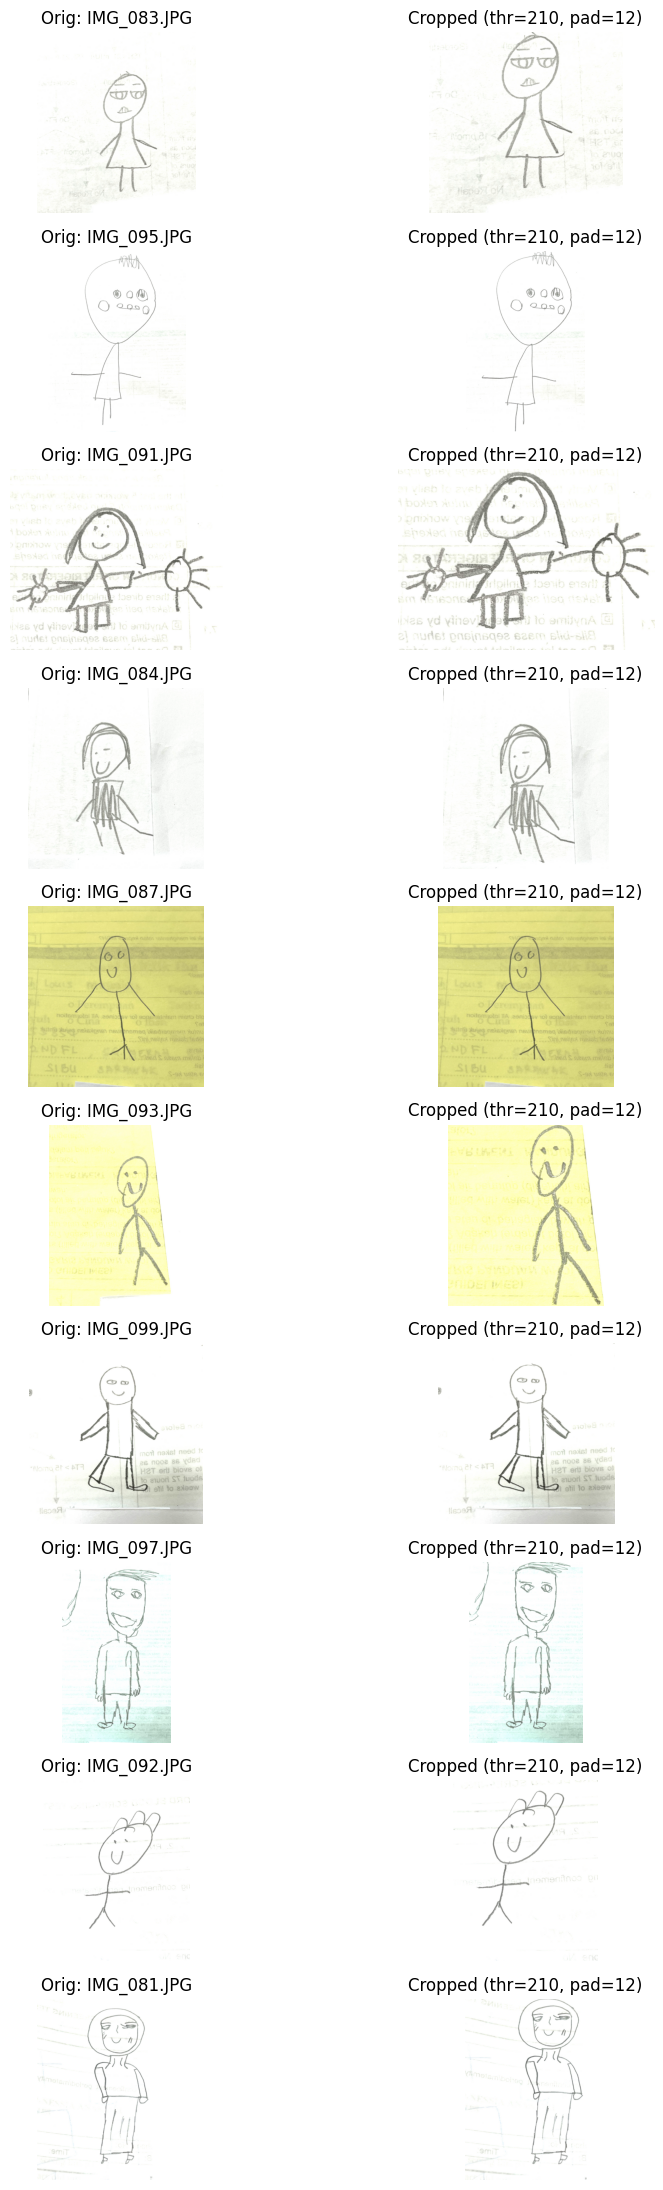

In [18]:
# --- CropToInk visual check (Orig vs Cropped) ---

import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

class CropToInk:
    def __init__(self, threshold: int = 245, pad: int = 12, min_size: int = 50):
        self.threshold = int(threshold)
        self.pad = int(pad)
        self.min_size = int(min_size)

    def __call__(self, img: Image.Image) -> Image.Image:
        g = img.convert("L")
        arr = np.array(g)
        mask = arr < self.threshold
        if int(mask.sum()) < self.min_size:
            return img
        ys, xs = np.where(mask)
        y0, y1 = int(ys.min()), int(ys.max())
        x0, x1 = int(xs.min()), int(xs.max())
        y0 = max(0, y0 - self.pad)
        x0 = max(0, x0 - self.pad)
        y1 = min(arr.shape[0] - 1, y1 + self.pad)
        x1 = min(arr.shape[1] - 1, x1 + self.pad)
        return img.crop((x0, y0, x1 + 1, y1 + 1))

def show_crop_preview(
    folder: str,
    n: int = 12,
    threshold: int = 245,
    pad: int = 12,
    min_size: int = 50,
    seed: int = 0,
    max_side: int = 700,
):
    """
    Grid: [Original | Cropped] for n images sampled from folder recursively.
    """
    folder = Path(folder)
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    files = [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    if not files:
        raise FileNotFoundError(f"No images found under: {folder.resolve()}")

    rng = np.random.default_rng(seed)
    n = min(n, len(files))
    pick = rng.choice(len(files), size=n, replace=False)
    pick_files = [files[i] for i in pick]

    cropper = CropToInk(threshold=threshold, pad=pad, min_size=min_size)

    def downscale(im: Image.Image) -> Image.Image:
        w, h = im.size
        s = max(w, h)
        if s <= max_side:
            return im
        scale = max_side / s
        return im.resize((int(w * scale), int(h * scale)))

    fig = plt.figure(figsize=(10, max(3, 2.2 * n)))

    for r, p in enumerate(pick_files):
        img = Image.open(p).convert("RGB")
        cropped = cropper(img)

        ax1 = fig.add_subplot(n, 2, r * 2 + 1)
        ax1.imshow(downscale(img))
        ax1.set_title(f"Orig: {p.name}")
        ax1.axis("off")

        ax2 = fig.add_subplot(n, 2, r * 2 + 2)
        ax2.imshow(downscale(cropped))
        ax2.set_title(f"Cropped (thr={threshold}, pad={pad})")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

# --- Run this (edit folder path) ---
show_crop_preview("img_dataset/val", n=10, threshold=210, pad=12, min_size=50, seed=12)
